### IEMS 394 PreProcessing

This notebook focuses on organising the preprocessing steps required to ready data for the biofuels optimisation model. For a full description, please refer to *IEMS394: Biofuels Final Report.pdf* which can be found in the corresponding [Biofuels github repo](www.github.com/iems394/blob/master).

In [1]:
%%time
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point, Polygon
from shapely.ops import cascaded_union
import shapely.geometry
import pandas as pd
import numpy as np
import geopandas as gpd
from tqdm import tqdm
import os, geojson, multiprocessing, datetime, time, geog, json, folium
import concurrent.futures
import branca.colormap as cm
# %matplotlib tk

os.chdir('/Users/saifbhatti/Desktop/Northwestern/sy1920/s20/iems394/client-data/cleaned_data')

with open('us_counties_2010.json', encoding = "ISO-8859-1") as f:
    gj = geojson.load(f)
selected_states = ['CA','MN','TX'] #for the purposes of this model, only three states were considered.
selected_states_fips = ['06','27','48'] #corresponding state FIPS codes
selected_states_dict = {'06':'CA','27':'MN','48':'TX'}

CPU times: user 3.02 s, sys: 310 ms, total: 3.33 s
Wall time: 3.34 s


In [2]:
EV_ranges_df =  pd.read_csv('EV_ranges.csv')
EV_ranges_df['Range'].mean()

109.3076923076923

#### Compiling Electric Fueling Stations by county

In [3]:
efuel_stations = pd.read_csv('electric_fuel_stations.csv')
efuel_stations['Points'] = list(zip(efuel_stations['Longitude'], efuel_stations['Latitude']))

In [4]:
def geo_mapper(x):
    '''
    geo_mapper takes pandas Series object constructed in the format (longitude, latitude).
    Taking this as the point, a geo.json file is imported containing all US counties from the 2010 census as polygons.
    It computes whether the point is within a polygon, and returns a list of all matches. 
    If a point is not matched, it returns None.
    '''
    point = Point(x)
    for i in range(len(gj['features'])):
        polygon = shape(gj['features'][i]['geometry'])
        if polygon.contains(point):
            return gj['features'][i]['properties']['NAME']

In [5]:
# counties = []
# points_list = list(efuel_stations['Points'])
# for i in tqdm(points_list):
#     counties.append(geo_mapper(i)) #takes 40 minutes to run
# efuel_stations['County'] = counties
# electric_fuel_df.to_csv('electric_fuel_stations.csv')

In [6]:
efuel_stations = efuel_stations[['Station Name','County','City','State','Points']]

#### Converting zipcode-level data to county-level data

In [7]:
tx_ev_vehicle_registered = pd.read_csv('vehicle_reg/tx_ev_registrations_public.csv')
print(len(tx_ev_vehicle_registered['ZIP Code'].unique())) #number of unique zipcodes with registered vehicles
print(len(tx_ev_vehicle_registered)) #number of registrations
# tx_ev_vehicle_registered.head()

1325
74143


In [8]:
mn_ev_vehicle_registered = pd.read_csv('vehicle_reg/mn_ev_registrations_public.csv')
mn_ev_vehicle_registered.drop(['VIN Prefix','VIN Model Year'],inplace=True,axis=1)
print(len(mn_ev_vehicle_registered['ZIP Code'].unique())) #number of unique zipcodes with registered vehicles
print(len(mn_ev_vehicle_registered)) #number of registrations
# mn_ev_vehicle_registered.head()

600
29248


In [9]:
result = pd.concat([mn_ev_vehicle_registered, tx_ev_vehicle_registered], axis=0)
print(len(result['ZIP Code'].unique()))
print(result.shape)  #MN + TX registrations
result.head()

1906
(103391, 5)


,DMV ID,ZIP Code,Registration Expiration Date,Registration Valid Date,Vehicle Name
0,6,55347.0,01/12/2020,30/01/2020,NaN
1,6,55432.0,01/12/2020,30/01/2020,NaN
2,6,55330.0,01/07/2020,30/01/2020,NaN
3,6,56377.0,01/04/2020,30/01/2020,NaN
4,6,55109.0,01/12/2020,30/01/2020,NaN


In [10]:
us_zips = pd.read_csv('uszips.csv')
print(us_zips.shape)
print(us_zips.columns)


(33099, 18)
Index(['zip', 'lat', 'lng', 'city', 'state_id', 'state_name', 'zcta',
       'parent_zcta', 'population', 'density', 'county_fips', 'county_name',
       'county_weights', 'county_names_all', 'county_fips_all', 'imprecise',
       'military', 'timezone'],
      dtype='object')


In [11]:
combo_zip_county = pd.merge(result, us_zips, how='inner', left_on='ZIP Code', right_on='zip')

In [12]:
print(len(combo_zip_county[(combo_zip_county['state_id'] == 'TX') | (combo_zip_county['state_id'] == 'MN')])) #how many within MN & TX
combo_zip_county = combo_zip_county[(combo_zip_county['state_id'] == 'TX') | (combo_zip_county['state_id'] == 'MN')]
print(combo_zip_county['state_id'].unique())
# new.to_csv('ev_registration_county.csv')


97888
['MN' 'TX']


In [13]:
cali = pd.read_csv('california_car_data.csv')
print(cali.columns)
# cali_vehicle_data = us_zips.merge(cali,right_on='Zip Code',left_on='zip').groupby('county_name').sum()
# cali_vehicle_data.reset_index(inplace=True)
# cali_vehicle_data = cali_vehicle_data[['county_name','population','Vehicles']]
# cali_vehicle_data.to_csv('2018cali_vehicle_data.csv')

# cali.Fuel.unique()
cali[cali['Fuel']=='Battery Electric']


Index(['Date', 'Zip Code', 'Model Year', 'Fuel', 'Make', 'Duty', 'Vehicles'], dtype='object')


/Users/saifbhatti/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Zip Code,Model Year,Fuel,Make,Duty,Vehicles
7,10/1/2018,90000,<2006,Battery Electric,OTHER/UNK,Heavy,4
19,10/1/2018,90001,2006,Battery Electric,OTHER/UNK,Light,1
81,10/1/2018,90001,2008,Battery Electric,OTHER/UNK,Light,1
208,10/1/2018,90001,2013,Battery Electric,OTHER/UNK,Light,1
236,10/1/2018,90001,2014,Battery Electric,OTHER/UNK,Light,1
...,...,...,...,...,...,...,...
586078,10/1/2018,Other,2017,Battery Electric,OTHER/UNK,Light,20
586119,10/1/2018,Other,2018,Battery Electric,OTHER/UNK,Light,16
586170,10/1/2018,Other,<2006,Battery Electric,GEM,Light,11
586171,10/1/2018,Other,<2006,Battery Electric,OTHER/UNK,Heavy,1


#### IRS / Median income data [source]??

##### Repeated county names

In [14]:
repeated_list = ['Orange','Cass','Lake','Trinity','Houston','Polk','Brown','Clay','Jackson','Washington','Martin']

In [15]:
tester = pd.read_csv('https://raw.githubusercontent.com/saif1457/iems394/master/data/testing%20county_renaming_engine.csv')
tester.loc[tester['County'].isin(repeated_list), 'County'] = tester['County'] + '_' + tester['State']
repeat_fixed = list(tester['County'])

#### E85 Fueling Stations and Viability Index Computations

In [16]:
e85 = pd.read_csv('e85_fuel_stations.csv')
e85['Points'] = list(zip(e85['Longitude'], e85['Latitude']))
e85 = e85[['Station Name','City','County', 'State','ZIP','Points']]
e85.groupby('County').count().sort_values(by='City', ascending=False).head(5)

,Station Name,City,State,ZIP,Points
County,,,,,
Montgomery,56,56,56,56,56
Hennepin,54,54,54,54,54
Polk,47,47,47,47,47
Harris,47,47,47,47,47
Cook,45,45,45,45,45


In [17]:
# counties = []
# points_list = list(e85['Points'])
# for i in tqdm(points_list): 
#     counties.append(geo_mapper(i))
# e85['County'] = counties
# e85.to_csv('e85_fuel_stations.csv')

In [18]:
e85_points = e85['Points']

In [19]:
geo_df = pd.DataFrame()
geo_df['points'] = e85_points
geometry_string = []

for i,j in tqdm(list(enumerate(e85_points))):
    p = Point(j)
    n_points = 20
    d = 10 * 1000 # meters --- 10km
    angles = np.linspace(0, 360, n_points)
    polygon = geog.propagate(p, angles, d)
#     print(json.dumps(shapely.geometry.mapping(shapely.geometry.Polygon(polygon))) + '\n')
#     geometry_list.append(json.dumps(shapely.geometry.mapping(shapely.geometry.Polygon(polygon))))
    geometry_string.append(shapely.geometry.Polygon(polygon))

geo_df['coordinates'] = geometry_string
geo_df['name'] = e85['County']
desc = []
for i in range(geo_df.shape[0]): desc.append('e85 station')
geo_df['description'] = desc

100%|██████████| 3561/3561 [00:00<00:00, 5873.57it/s]


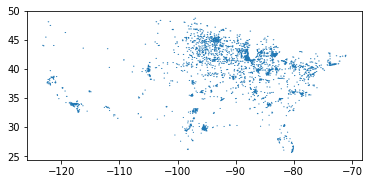

In [20]:
boundary = gpd.GeoSeries(cascaded_union(geometry_string))
boundary.plot()
boundary = boundary.to_frame()
plt.show()

In [21]:
type(boundary)
boundary
from geopandas import GeoDataFrame
gdf = GeoDataFrame(geometry=boundary[0])
gdf['name'] = 'e85_stations'
gdf

,geometry,name
0,(POLYGON ((-98.08867913743886 26.1813911433433...,e85_stations


Ok let's not reinvent the wheel here. The basic steps I have taken towards an Fueling Viability Index (FVI) is to take points of the fueling station, convert it into a multiPolygon (many sided polygon - or in other words, a circle with a specified radius), and then created a union of these. The entire union is called a `GeoSeries` (denoted as `boundary`) and now I want to run one final operation: compute the area overlap between `boundary` and any given county.

In [22]:
uscs = gpd.read_file('/Users/saifbhatti/Downloads/gz_2010_us_050_00_500k/gz_2010_us_050_00_500k.shp')
print(uscs.columns)
# us_county_shapefile['STATEFP'].unique()
# uscs[(uscs['STATE']=='06') | (uscs['STATE']=='27') | (uscs['STATE']=='48')]
uscs = uscs[uscs['STATE'].isin(selected_states_fips)]
#tester.loc[tester['County'].isin(repeated_list), 'County'] = tester['County'] + '_' + tester['State']
uscs.reset_index(drop=True,inplace=True)
uscs = uscs.replace({'STATE':selected_states_dict})
uscs.loc[uscs['NAME'].isin(repeated_list), 'NAME'] = uscs['NAME'] + '_' + uscs['STATE']
uscs.head(5)

Index(['GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA', 'geometry'], dtype='object')


,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,0500000US06035,CA,035,Lassen,County,4541.184,"POLYGON ((-119.9986710353 40.77952146652979, -..."
1,0500000US06049,CA,049,Modoc,County,3917.770,"POLYGON ((-120.488221960818 41.9937363458679, ..."
2,0500000US06075,CA,075,San Francisco,County,46.873,"(POLYGON ((-123.013915661213 37.7003546200356,..."
3,0500000US06083,CA,083,Santa Barbara,County,2735.085,"(POLYGON ((-119.789798 34.05726, -119.770729 3..."
4,0500000US06091,CA,091,Sierra,County,953.214,"POLYGON ((-120.003117296548 39.4450437274505, ..."


In [23]:
e85_vi = pd.DataFrame(columns = ['county','e85 station','e85_area'])

In [24]:
geom_p1 = list(uscs['geometry'])
geom_p8 = list(gdf['geometry'])

In [25]:
for i,g1 in tqdm(enumerate(geom_p1)):
    for j, g8 in enumerate(geom_p8):
        if g1.intersects(g8):
            df1 = pd.DataFrame([[i,j,(g1.intersection(g8).area/g1.area)*100]],columns = ['county','e85 station','e85_area'])
            e85_vi = e85_vi.append(df1)

399it [00:52,  7.62it/s]


In [26]:
inplaced = e85_vi.set_index('county')

In [27]:
e85_vi = pd.merge(uscs,inplaced,how='outer',left_index=True,right_index=True).fillna(0)
e85_vi.groupby('NAME').sum().sort_values(by='e85_area',ascending=False).head(10)

,CENSUSAREA,e85 station,e85_area
NAME,,,
Ramsey,152.212,0,100.000000
Hennepin,553.591,0,97.992623
San Francisco,46.873,0,97.863084
Carver,354.325,0,94.161980
Dakota,562.168,0,88.115877
Harris,1703.478,0,87.520125
Anoka,423.010,0,87.060826
Chisago,414.862,0,86.179595
Olmsted,653.349,0,83.730790


In [28]:
efuel_stations.head(5)

,Station Name,County,City,State,Points
0,City of Sacramento - Capitol Parking Garage,Sacramento,Sacramento,CA,"(-121.4926, 38.578380200000005)"
1,LADWP - Truesdale Center,Los Angeles,Sun Valley,CA,"(-118.38797140000001, 34.24831915)"
2,Southern California Edison - Rosemead Office B...,Los Angeles,Rosemead,CA,"(-118.081014, 34.050745)"
3,Los Angeles Convention Center,Los Angeles,Los Angeles,CA,"(-118.26876200000001, 34.04057)"
4,LADWP - John Ferraro Building,Los Angeles,Los Angeles,CA,"(-118.24819, 34.058476)"


In [29]:
efuel_points = efuel_stations['Points']
geo_df = pd.DataFrame()
geo_df['points'] = efuel_points
geometry_string = []

for i,j in tqdm(list(enumerate(efuel_points))):
    p = Point(j)
    n_points = 20
    d = 10 * 1000 # meters --- 10km
    angles = np.linspace(0, 360, n_points)
    polygon = geog.propagate(p, angles, d)
    geometry_string.append(shapely.geometry.Polygon(polygon))

geo_df['coordinates'] = geometry_string
geo_df['name'] = efuel_stations['County']
desc = []
for i in range(geo_df.shape[0]): desc.append('efuel station')
geo_df['description'] = desc

100%|██████████| 27822/27822 [00:05<00:00, 5473.36it/s]


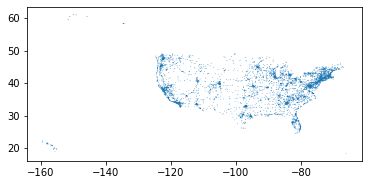

In [30]:
boundary = gpd.GeoSeries(cascaded_union(geometry_string))
boundary.plot()
boundary = boundary.to_frame()
plt.show()

In [31]:
type(boundary)
boundary
from geopandas import GeoDataFrame
gdf = GeoDataFrame(geometry=boundary[0])
gdf['name'] = 'efuel_stations'
gdf

,geometry,name
0,(POLYGON ((-66.01348310250545 18.3698500626044...,efuel_stations


In [32]:
geom_p1 = list(uscs['geometry'])
geom_p8 = list(gdf['geometry'])

In [33]:
efuels_vi = pd.DataFrame(columns = ['county','electric fuel station','efuels_area'])

In [34]:
for i,g1 in tqdm(enumerate(geom_p1)):
    for j, g8 in enumerate(geom_p8):
        if g1.intersects(g8):
            df1 = pd.DataFrame([[i,j,(g1.intersection(g8).area/g1.area)*100]],columns = ['county','electric fuel station','efuels_area'])
            efuels_vi = efuels_vi.append(df1)

399it [02:12,  3.00it/s]


In [35]:
inplaced = efuels_vi.set_index('county')

In [36]:
efuels_vi = pd.merge(uscs,inplaced,how='outer',left_index=True,right_index=True).fillna(0)
efuels_vi.groupby('NAME').sum().sort_values(by='efuels_area',ascending=False).head(10)

,CENSUSAREA,electric fuel station,efuels_area
NAME,,,
Ramsey,152.212,0,100.000000
Dallas,871.279,0,98.564965
San Francisco,46.873,0,98.307727
Orange_CA,790.568,0,96.638386
Contra Costa,715.937,0,95.394906
Hennepin,553.591,0,92.361867
Harris,1703.478,0,90.571560
Tarrant,863.608,0,88.031170
Rockwall,127.036,0,86.352167


In [37]:
# efuels_vi[efuels_vi['NAME'].isin(repeat_fixed)]
efuels_vi[efuels_vi['NAME'] == 'Orange_CA']
efuels_vi.to_csv('efuels_vi.csv')

In [38]:
e85_vi[e85_vi['NAME'] == 'Orange_CA']
e85_vi.to_csv('e85_vi.csv')

In [39]:
visual_df = pd.read_csv('https://raw.githubusercontent.com/saif1457/iems394/master/data/visual_df.csv')
visual_df.drop(visual_df.columns[0], axis=1,inplace=True)
visual_df['county'] = visual_df['County'].str.split('_').apply(lambda x: x[0])

In [40]:
with open('us_counties_2010.json', encoding = "ISO-8859-1") as f:
    gj = geojson.load(f)

In [41]:
cookie = gpd.GeoDataFrame(gj['features'])
for i in tqdm(range(cookie.shape[0])):
    cookie['properties'][i]['NAME'] = cookie['properties'][i]['NAME'].replace('_',' ')
    cookie['properties'][i]['STATE'] = cookie['properties'][i]['STATE'].replace('06','CA')
    cookie['properties'][i]['STATE'] = cookie['properties'][i]['STATE'].replace('27','MN')
    cookie['properties'][i]['STATE'] = cookie['properties'][i]['STATE'].replace('48','TX')
    if cookie['properties'][i]['STATE'] in selected_states:
        cookie['properties'][i]['NAME'] = cookie['properties'][i]['NAME'] + '_' + cookie['properties'][i]['STATE']

100%|██████████| 3221/3221 [00:00<00:00, 4798.37it/s]


In [57]:
# visual_df[visual_df['county'] == 'Orange']
visual_df[visual_df['County']=='Ramsey_MN']

,County,annual_ghg_emissions,annual_operating_cost,total_annual_cost,annual_fuel_use,total_vehicle_count,vehicle_split_bev,vehicle_split_ffv,vehicle_split_sidi,county,state
283,Ramsey_MN,2.138466e+11,16908158.0,359955430.0,12906991.0,52410.0,0.0,0.0,100.0,Ramsey,MN


In [43]:
visual_dict = visual_df.drop(['county','state'],axis=1).set_index('County').T.to_dict()

In [44]:
visual_dict['Aitkin_MN']

{'annual_ghg_emissions': 2330480570000.0,
 'annual_operating_cost': 380490050.0,
 'total_annual_cost': 7422482300.0,
 'annual_fuel_use': 171742756.0,
 'total_vehicle_count': 1217268.96,
 'vehicle_split_bev': 84.6,
 'vehicle_split_ffv': 15.4,
 'vehicle_split_sidi': 0.0}

In [45]:
counties_list = list(visual_df['County'])

In [46]:
dictionary1 = {'STATE': '06'}
dictionary1

{'STATE': '06'}

In [47]:
selected_states_dict

{'06': 'CA', '27': 'MN', '48': 'TX'}

In [48]:
{k: selected_states_dict.get(v, v) for k, v in dictionary1.items()}

{'STATE': 'CA'}

In [49]:
d1 = {1: 1, 2: 2}
d2 = {2: 'ha!', 3: 3}
d1.update(d2)
d1

{1: 1, 2: 'ha!', 3: 3}

In [50]:
counter = []
for i,j in enumerate(gj['features']):
#     dictionary1 = 
    
#     gj['features'][i]['properties'] = {k: selected_states_dict.get(v, v) for k, v in dictionary1.items()}
    if gj['features'][i]['properties']['NAME'] in counties_list:
        counter.append(1)
        gj['features'][i]['properties'].update(visual_dict[gj['features'][i]['properties']['NAME']])

In [51]:
len(counter)

399

In [52]:
# for i,j in enumerate(gj['features']):
#     print(gj['features'][i]['properties'])
gj['features'][200]['properties']

{'GEO_ID': '0500000US06003',
 'STATE': 'CA',
 'COUNTY': '003',
 'NAME': 'Alpine_CA',
 'LSAD': 'County',
 'CENSUSAREA': 738.332,
 'annual_ghg_emissions': 4144050400.0,
 'annual_operating_cost': 881119.3500000002,
 'total_annual_cost': 11305466.8,
 'annual_fuel_use': 334471.05199999997,
 'total_vehicle_count': 1697.0,
 'vehicle_split_bev': 44.8,
 'vehicle_split_ffv': 0.0,
 'vehicle_split_sidi': 55.2}

In [53]:
from geojson import dump
# with open('us_counties_2010.json', encoding = "ISO-8859-1") as f:
#     gj = geojson.load(f)

with open('myfile.geojson', 'w') as f:
    dump(gj, f)

In [54]:
print(visual_df.annual_ghg_emissions.quantile(0))
print(visual_df.annual_ghg_emissions.quantile(0.2))
print(visual_df.annual_ghg_emissions.quantile(0.4))
print(visual_df.annual_ghg_emissions.quantile(0.6))
print(visual_df.annual_ghg_emissions.quantile(0.7))
print(visual_df.annual_ghg_emissions.quantile(0.8))
print(visual_df.annual_ghg_emissions.quantile(0.9))

229084984.0
30012953800.000008
69309903600.0
143996466102.4
219972622399.99988
369871720600.00037
1058990873599.9991


In [55]:
# gj

In [56]:
# m = folium.Map(location=[39.8333333, -98.585522], zoom_start=5)
# folium.Choropleth(geo_data = gj,
#                  name='choropleth',
#                  data=visual_df,
#                  columns = ['County','vehicle_count_ffv'],
#                  key_on = 'feature.properties.NAME',
#                  nan_fill_opacity='D3D3D3',
#                  fill_colour = 'Y1Gn',
#                  fill_color='YlGn',
#                  fill_opacity=0.7,
#                  line_opacity=0.2,
#                   bins=[0,10,20,30,40,50,60,70,90,100],
#                  legend_name='Vehicle Count)',
#                 highlight=True).add_to(m)
# folium.LayerControl().add_to(m)
# m

[possible solution](https://stackoverflow.com/questions/38014480/python-folium-choropleth-map-keyerror-none)

[optimal](https://leafletjs.com/examples/choropleth/example.html)